# Clustering 3K PBMCs with Variational Autoencoders

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import os

from utils import plot_results_pca, plot_results_umap
from VAE import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Data preprocessing

In [3]:
data_path = '../data/proc/pbmc10k.h5ad'

In [4]:
adata = sc.read_h5ad(data_path)

In [5]:
adata.obs.shape

(7756, 4)

In [6]:
adata.obs.head()

,n_genes,percent_mito,n_counts,louvain
index,,,,
AAACCCAAGATTGTGA-1,2194,0.084903,6160.0,0
AAACCCACATCGGTTA-1,2093,0.061820,6713.0,7
AAACCCAGTACCGCGT-1,1518,0.078911,3637.0,0
AAACCCAGTATCGAAA-1,737,0.088424,1244.0,2
AAACCCAGTCGTCATA-1,1240,0.059747,2611.0,2


In [7]:
adata.var.shape

(1972, 7)

In [8]:
adata.var.head()

,gene_ids,feature_types,n_cells,highly_variable,means,dispersions,dispersions_norm
index,,,,,,,
HES4,ENSG00000188290,Gene Expression,131,True,0.045170,1.462180,1.151113
ISG15,ENSG00000187608,Gene Expression,2282,True,0.697626,1.660043,1.234033
C1orf159,ENSG00000131591,Gene Expression,223,True,0.070364,1.314917,0.663855
TNFRSF18,ENSG00000186891,Gene Expression,373,True,0.133355,1.470949,1.180127
TNFRSF4,ENSG00000186827,Gene Expression,533,True,0.207609,1.508394,1.304025


In [9]:
adata.var_names

Index(['HES4', 'ISG15', 'C1orf159', 'TNFRSF18', 'TNFRSF4', 'AL645728.1',
       'MIB2', 'MMP23B', 'MORN1', 'TNFRSF14-AS1',
       ...
       'MX1', 'PWP2', 'AP001059.3', 'AP001059.2', 'COL6A2', 'LSS', 'C21orf58',
       'PCNT', 'DIP2A', 'S100B'],
      dtype='object', name='index', length=1972)

In [10]:
gene_names = adata.var_names.values

In [11]:
data = adata.X
#data = normalize(data, axis=-1, order=2)
print(np.any(np.isnan(data)))

False


### Embedding

In [12]:
scaler = StandardScaler()
scaler.fit(data)
data = scaler.transform(data)

In [13]:
genes_encoder = LabelEncoder()
genes_encoded = genes_encoder.fit_transform(gene_names)
print(genes_encoded)

[ 820  942  322 ... 1330  580 1538]


In [14]:
genes_OHE = to_categorical(genes_encoded)

In [15]:
from numpy import argmax

inverted = genes_encoder.inverse_transform([argmax(genes_OHE[0, :])])
print(inverted)

['HES4']


In [16]:
inverted = argmax(genes_OHE[0])
print(inverted)

820


## Variational Autoencoder Model

### Network parameters

In [17]:
original_dim = data.shape[1]

layer_1_dim = 100
layer_2_dim = 50
layer_3_dim = 50
batch_size = 35
latent_dim = 50
epochs = 500

In [18]:
encoder, decoder, vae = build_VAE(original_dim, latent_dim, layer_1_dim, layer_2_dim, layer_3_dim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1972)         0                                            
__________________________________________________________________________________________________
DO (Dropout)                    (None, 1972)         0           X[0][0]                          
__________________________________________________________________________________________________
H1 (Dense)                      (None, 100)          197200      DO[0][0]                         
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H1[0][0]                         
____________________________________________________________________________________________

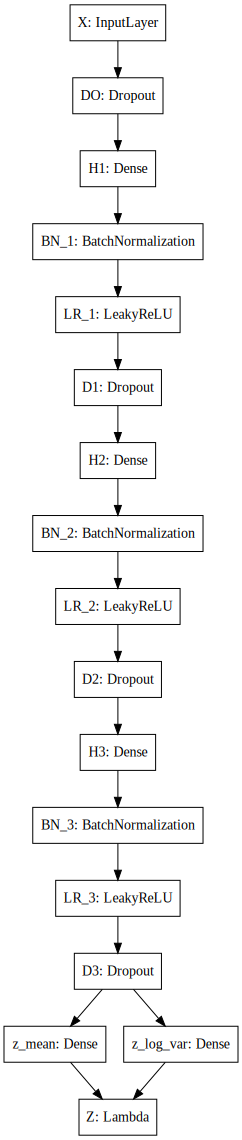

In [19]:
print("\nEncoder Network")
print("===============")
print(encoder.summary())
os.makedirs('../graphs', exist_ok=True)
plot_model(encoder, to_file='../graphs/vae_encoder.png', show_shapes=True)
SVG(model_to_dot(encoder).create(prog='dot', format='svg'))


Decoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Z (InputLayer)               (None, 50)                0         
_________________________________________________________________
DO (Dropout)                 (None, 50)                0         
_________________________________________________________________
H1 (Dense)                   (None, 50)                2500      
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 50)                200       
_________________________________________________________________
LR_1 (LeakyReLU)             (None, 50)                0         
_________________________________________________________________
D1 (Dropout)                 (None, 50)                0         
_________________________________________________________________
H2 (Dense)                   (None, 50)                2500

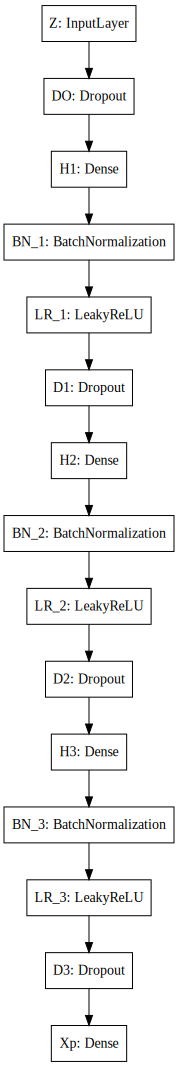

In [20]:
print("\nDecoder Network")
print("===============")
print(decoder.summary())
plot_model(decoder, to_file='../graphs/vae_decoder.png', show_shapes=True)
SVG(model_to_dot(decoder).create(prog='dot', format='svg'))


Autoencoder Network
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 1972)              0         
_________________________________________________________________
encoder (Model)              [(None, 50), (None, 50),  210600    
_________________________________________________________________
decoder (Model)              (None, 1972)              209972    
Total params: 420,572
Trainable params: 419,772
Non-trainable params: 800
_________________________________________________________________


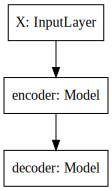

In [21]:
print("\nAutoencoder Network")
print("===================")
vae.summary()
plot_model(decoder, to_file='../graphs/vae_autoencoder.png', show_shapes=True)
SVG(model_to_dot(vae).create(prog='dot', format='svg'))

### Model training

In [22]:
os.makedirs('../models', exist_ok=True)

vae_history = train_VAE(vae, data, batch_size, epochs)

# save model in h5 format
vae.save('../models/vae.h5')

Instructions for updating:
Use tf.cast instead.
Train on 6204 samples, validate on 1552 samples
Epoch 1/500
6204/6204 [==============================] - 6s 941us/step - loss: 2326.3730 - val_loss: 2254.5421
Epoch 2/500
6204/6204 [==============================] - 3s 411us/step - loss: 2109.6791 - val_loss: 2124.1774
Epoch 3/500
6204/6204 [==============================] - 2s 365us/step - loss: 2045.3757 - val_loss: 2067.0747
Epoch 4/500
6204/6204 [==============================] - 2s 361us/step - loss: 2013.4042 - val_loss: 2023.3771
Epoch 5/500
6204/6204 [==============================] - 2s 375us/step - loss: 1988.0731 - val_loss: 2007.8357
Epoch 6/500
6204/6204 [==============================] - 2s 337us/step - loss: 1975.2855 - val_loss: 1998.2116
Epoch 7/500
6204/6204 [==============================] - 2s 355us/step - loss: 1966.8644 - val_loss: 1989.6602
Epoch 8/500
6204/6204 [==============================] - 2s 331us/step - loss: 1958.5164 - val_loss: 1976.7484
Epoch 9/500
6204

6204/6204 [==============================] - 3s 429us/step - loss: 1872.9949 - val_loss: 1897.3014
Epoch 72/500
6204/6204 [==============================] - 2s 332us/step - loss: 1872.3026 - val_loss: 1896.8266
Epoch 73/500
6204/6204 [==============================] - 2s 322us/step - loss: 1871.8956 - val_loss: 1896.6430
Epoch 74/500
6204/6204 [==============================] - 2s 351us/step - loss: 1871.6075 - val_loss: 1896.0982
Epoch 75/500
6204/6204 [==============================] - 2s 350us/step - loss: 1871.1439 - val_loss: 1895.8275
Epoch 76/500
6204/6204 [==============================] - 2s 391us/step - loss: 1870.5289 - val_loss: 1895.3701
Epoch 77/500
6204/6204 [==============================] - 3s 434us/step - loss: 1870.6198 - val_loss: 1894.9692
Epoch 78/500
6204/6204 [==============================] - 3s 435us/step - loss: 1870.0646 - val_loss: 1894.6175
Epoch 79/500
6204/6204 [==============================] - 2s 395us/step - loss: 1869.4712 - val_loss: 1894.0628
Epoch

Epoch 144/500
6204/6204 [==============================] - 2s 296us/step - loss: 1858.5300 - val_loss: 1885.0633
Epoch 145/500
6204/6204 [==============================] - 2s 282us/step - loss: 1858.8677 - val_loss: 1884.3979
Epoch 146/500
6204/6204 [==============================] - 2s 297us/step - loss: 1859.0744 - val_loss: 1884.5481
Epoch 147/500
6204/6204 [==============================] - 2s 303us/step - loss: 1857.9624 - val_loss: 1884.3827
Epoch 148/500
6204/6204 [==============================] - 2s 313us/step - loss: 1858.5759 - val_loss: 1884.4563
Epoch 149/500
6204/6204 [==============================] - 2s 295us/step - loss: 1858.0453 - val_loss: 1884.1412
Epoch 150/500
6204/6204 [==============================] - 2s 367us/step - loss: 1858.4491 - val_loss: 1883.9597
Epoch 151/500
6204/6204 [==============================] - 2s 387us/step - loss: 1858.2609 - val_loss: 1884.0162
Epoch 152/500
6204/6204 [==============================] - 2s 338us/step - loss: 1857.5246 - val

6204/6204 [==============================] - 2s 340us/step - loss: 1853.9480 - val_loss: 1881.0540
Epoch 217/500
6204/6204 [==============================] - 2s 367us/step - loss: 1853.8822 - val_loss: 1880.6994
Epoch 218/500
6204/6204 [==============================] - 2s 373us/step - loss: 1854.1143 - val_loss: 1880.5591
Epoch 219/500
6204/6204 [==============================] - 2s 401us/step - loss: 1853.3033 - val_loss: 1880.6209
Epoch 220/500
6204/6204 [==============================] - 3s 442us/step - loss: 1853.5698 - val_loss: 1880.6353
Epoch 221/500
6204/6204 [==============================] - 2s 369us/step - loss: 1854.1722 - val_loss: 1880.7474
Epoch 222/500
6204/6204 [==============================] - 2s 316us/step - loss: 1854.1398 - val_loss: 1880.5291
Epoch 223/500
6204/6204 [==============================] - 2s 358us/step - loss: 1853.8123 - val_loss: 1880.8376
Epoch 224/500
6204/6204 [==============================] - 3s 512us/step - loss: 1853.3913 - val_loss: 1880.54

6204/6204 [==============================] - 2s 305us/step - loss: 1851.8482 - val_loss: 1879.3468
Epoch 289/500
6204/6204 [==============================] - 2s 275us/step - loss: 1852.1559 - val_loss: 1879.6754
Epoch 290/500
6204/6204 [==============================] - 2s 310us/step - loss: 1850.8562 - val_loss: 1878.9436
Epoch 291/500
6204/6204 [==============================] - 2s 298us/step - loss: 1851.3978 - val_loss: 1879.3221
Epoch 292/500
6204/6204 [==============================] - 2s 298us/step - loss: 1851.4410 - val_loss: 1879.1975
Epoch 293/500
6204/6204 [==============================] - 2s 281us/step - loss: 1851.6063 - val_loss: 1879.2855
Epoch 294/500
6204/6204 [==============================] - 2s 270us/step - loss: 1851.7552 - val_loss: 1879.1770
Epoch 295/500
6204/6204 [==============================] - 2s 287us/step - loss: 1850.6287 - val_loss: 1879.0947
Epoch 296/500
6204/6204 [==============================] - 2s 325us/step - loss: 1851.3551 - val_loss: 1879.10

6204/6204 [==============================] - 2s 291us/step - loss: 1850.2415 - val_loss: 1878.4208
Epoch 361/500
6204/6204 [==============================] - 2s 291us/step - loss: 1849.7457 - val_loss: 1878.4594
Epoch 362/500
6204/6204 [==============================] - 1s 227us/step - loss: 1849.5696 - val_loss: 1878.4567
Epoch 363/500
6204/6204 [==============================] - 2s 246us/step - loss: 1849.8470 - val_loss: 1878.2414
Epoch 364/500
6204/6204 [==============================] - 2s 253us/step - loss: 1849.7039 - val_loss: 1878.3263
Epoch 365/500
6204/6204 [==============================] - 2s 265us/step - loss: 1850.0380 - val_loss: 1878.6813
Epoch 366/500
6204/6204 [==============================] - 2s 259us/step - loss: 1850.1328 - val_loss: 1878.3055
Epoch 367/500
6204/6204 [==============================] - 2s 344us/step - loss: 1850.1179 - val_loss: 1878.4288
Epoch 368/500
6204/6204 [==============================] - 2s 283us/step - loss: 1849.4924 - val_loss: 1878.51

6204/6204 [==============================] - 2s 277us/step - loss: 1848.5494 - val_loss: 1878.1459
Epoch 433/500
6204/6204 [==============================] - 2s 290us/step - loss: 1848.7992 - val_loss: 1877.7397
Epoch 434/500
6204/6204 [==============================] - 2s 307us/step - loss: 1848.9276 - val_loss: 1877.9890
Epoch 435/500
6204/6204 [==============================] - 2s 303us/step - loss: 1848.7877 - val_loss: 1877.9336
Epoch 436/500
6204/6204 [==============================] - 2s 302us/step - loss: 1848.6220 - val_loss: 1877.8267
Epoch 437/500
6204/6204 [==============================] - 2s 281us/step - loss: 1849.0204 - val_loss: 1878.1495
Epoch 438/500
6204/6204 [==============================] - 2s 298us/step - loss: 1848.8311 - val_loss: 1878.0479
Epoch 439/500
6204/6204 [==============================] - 2s 302us/step - loss: 1848.4687 - val_loss: 1878.1762
Epoch 440/500
6204/6204 [==============================] - 2s 322us/step - loss: 1848.1161 - val_loss: 1878.16

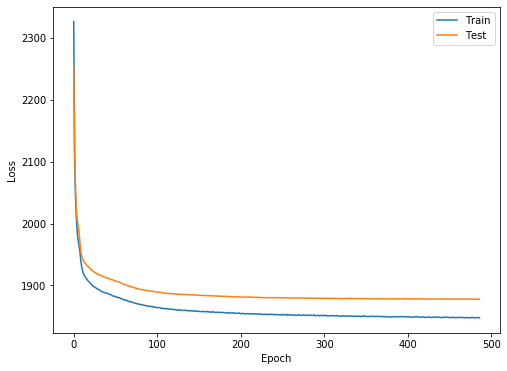

In [23]:
# Plot training & validation loss values
plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(vae_history.history['loss'])
plt.plot(vae_history.history['val_loss'])
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([570,700])
#plt.loglog()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

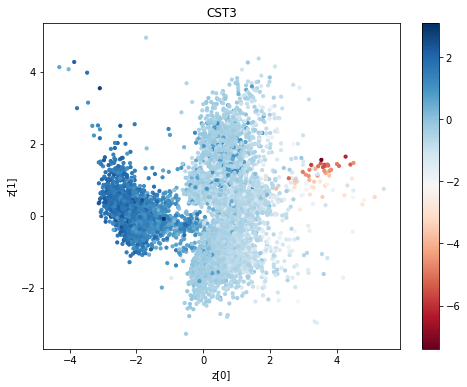

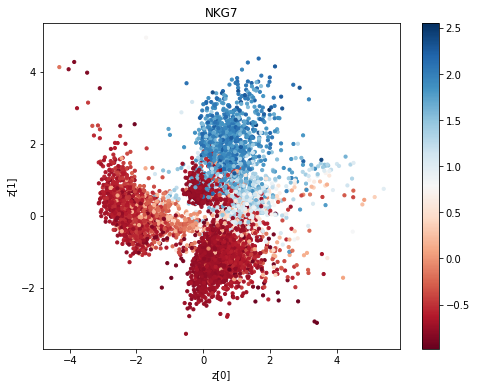

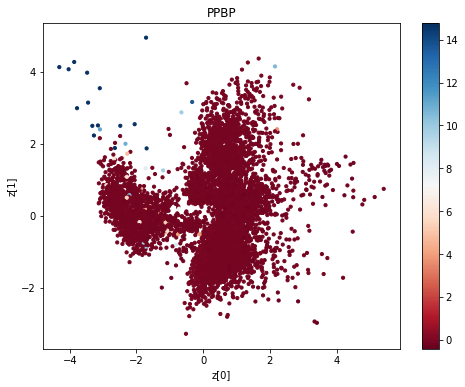

In [24]:
models = (encoder, decoder)
gene_list = ['CST3', 'NKG7', 'PPBP']
plot_results_pca(models, data, gene_list, gene_names, latent_dim)

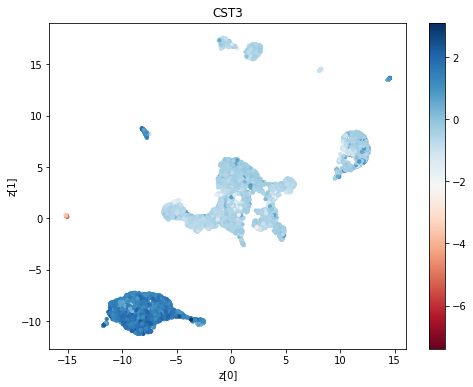

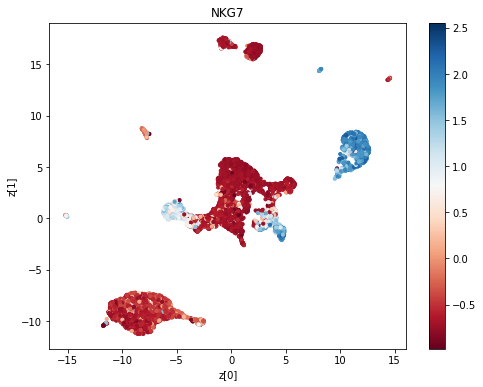

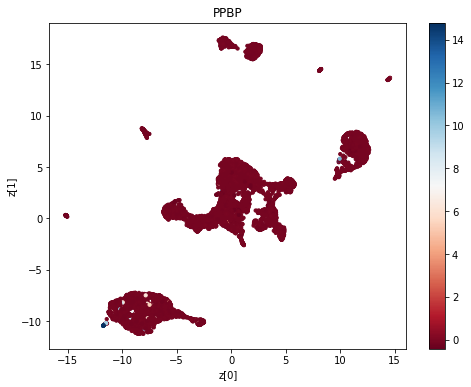

In [25]:
models = (encoder, decoder)
gene_list = ['CST3', 'NKG7', 'PPBP']
plot_results_umap(models, data, gene_list, gene_names, latent_dim)